In [1]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd
import random
from matplotlib.patches import Ellipse
import ligo.skymap.plot
from scipy.optimize import minimize
import numdifftools as ndt

In [2]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/' # my cache path
v_dir = '/pscratch/sd/j/jjpim/massmag/'

# load updated master table
tf_mastertable = Table.read(data_dir + 'tf_mastertable_massmag.fits') 

#load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

#new column in tf mastertable
tf_mastertable['M_STELLAR_CIGALE']=np.nan
tf_mastertable['M_STELLAR_CIGALE_ERR']=np.nan
tf_mastertable['M_STELLAR_PROVABGS']=np.nan
tf_mastertable['M_STELLAR_PROVABGS_ERR']=np.nan

In [3]:
# read in cigale sv3 table
cigale = Table.read('/global/cfs/cdirs/desi/public/edr/vac/edr/cigale/fuji/v1.1/FujiPhysProp_v1.1.fits')
#read in provabgs table
provabgs = Table.read('/global/cfs/cdirs/desi/public/edr/vac/edr/provabgs/v1.0/BGS_ANY_full.provabgs.sv3.v0.hdf5')
provabgs

TARGETID,RA,DEC,Z_HP,ZERR,TSNR2_BGS,MAG_G,MAG_R,MAG_Z,MAG_W1,FIBMAG_R,HPIX_64,PROVABGS_MCMC,PROVABGS_THETA_BF,PROVABGS_Z_MAX,PROVABGS_LOGMSTAR_BF,PROVABGS_LOGMSTAR,SCHLEGEL_COLOR,PROVABGS_W_ZFAIL,PROVABGS_W_FIBASSIGN,IS_BGS_BRIGHT,IS_BGS_FAINT
int64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,"float64[100,13]",float64[13],float64,float64,float64[100],float64,float64,float64,bool,bool
39633390185481181,191.17913199949842,60.25733587654764,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633390164510024,188.6998080571996,60.21175772175424,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,3.225,False,False
39633390185480955,191.14955067198017,60.34047183206205,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633390185480938,191.14757099005186,60.345815959235,0.2819459922463374,2.191690764397e-05,1361.7778,20.420939956138607,19.440977833152942,18.807486906915823,18.725561063547207,21.083244145949642,11226,11.091623656909688 .. 0.3684622521221414,11.14249424405227 .. 0.3651476796540595,0.2891440449335749,10.894820213317871,10.848259925842285 .. 10.952618598937988,0.1059712957858181,1.0671457830611217,3.0714285714285716,True,False
39633416324383107,187.05117249536465,62.614542270156655,0.2703579310142208,0.00018002802349298926,1218.0295,20.876585604498494,19.373871860075226,18.567397256862876,18.32574859422363,20.212708263179056,11251,11.127879812361321 .. 0.6691898790548064,11.16028636319183 .. 0.6710591095679554,0.2822033708476234,10.909546852111816,10.877055168151855 .. 10.874772071838379,-0.3616078306686752,1.005530547154544,1.0,True,False
39633393155049062,187.8080794399063,60.39356441584356,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633393155049303,187.83760708675698,60.38987543677365,0.1731108191825362,2.1990725452772437e-05,1234.5317,19.69273753706838,18.892550253715136,18.34277957526595,18.565848448993197,21.00700131929247,11237,10.462320138967206 .. 0.2729800106294297,10.502975152735333 .. 0.2744993206027024,0.21924790414805623,10.27071762084961,10.239782333374023 .. 10.281316757202148,0.01670638624886256,1.0556176146427896,1.8169014084507042,True,False
39633393155049428,187.8512261193913,60.382096424983686,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,2.1864406779661016,False,False
39633390164510257,188.7298325265811,60.181046704454054,0.2854181586411897,8.005616412868143e-06,1080.5574,20.021376563811977,19.091834839420468,18.488285412624066,18.38746082854565,20.641812033703985,11237,11.113035968148562 .. 0.3947223033620342,11.257075728183183 .. 0.3983021711356034,0.32988420863892076,11.017786979675293,10.893733024597168 .. 11.032293319702148,0.18537451480860634,1.0209118095758252,3.6857142857142855,True,False


In [4]:
targets = []
target_ids = tf_mastertable['TARGETID'][tf_mastertable['M_R26'] > 0]

# find cigale targets
for target_id in target_ids:
    if len(cigale[cigale['TARGETID'] == target_id]) > 0:
        targets.append(target_id)

# extract stellar masses for cigale and update tf_mastertable        
for target_id in targets:
    stellar_mass = cigale[cigale['TARGETID'] == target_id]['LOGM'][0]
    stellar_mass_err = cigale[cigale['TARGETID'] == target_id]['LOGM_ERR'][0]
    sga_id = tf_mastertable[tf_mastertable['TARGETID'] == target_id]['SGA_ID'][0]
    tf_mastertable['M_STELLAR_CIGALE'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, tf_mastertable['M_R26'] > 0)] = stellar_mass
    tf_mastertable['M_STELLAR_CIGALE_ERR'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, tf_mastertable['M_R26'] > 0)] = stellar_mass_err

# put target ids in list if mass exists
targets_2 = []
target_ids_2 = tf_mastertable['TARGETID'][tf_mastertable['M_R26'] > 0]

# finding provabgs targets
for target_id in target_ids_2:
    if len(provabgs[provabgs['TARGETID'] == target_id]) > 0:
        targets_2.append(target_id)

# extract stellar masses for provabgs and update tf_mastertable
for target_id in targets_2:
    stellar_mass = provabgs[provabgs['TARGETID'] == target_id]['PROVABGS_LOGMSTAR_BF'][0]
    log_stellar_mass_samples = provabgs[provabgs['TARGETID'] == target_id]['PROVABGS_LOGMSTAR'].data[0]
    stellar_mass_samples_linear = 10 ** log_stellar_mass_samples
    std_linear = np.std(stellar_mass_samples_linear)
    mean_linear = np.mean(stellar_mass_samples_linear)
    std_log = std_linear / mean_linear

    sga_id = tf_mastertable[tf_mastertable['TARGETID'] == target_id]['SGA_ID'][0]
    tf_mastertable['M_STELLAR_PROVABGS'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, tf_mastertable['M_R26'] > 0)] = stellar_mass
    tf_mastertable['M_STELLAR_PROVABGS_ERR'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, tf_mastertable['M_R26'] > 0)] = std_log

/tmp/ipykernel_1696385/1724980054.py:33: RuntimeWarning: invalid value encountered in double_scalars
  std_log = std_linear / mean_linear


In [8]:
#convert the tf_mastertable targetids to a set
tf_mastertable_targetids = set(tf_mastertable['TARGETID'].data)

#find the common targetids
common_targetids = np.intersect1d(list(targets_2), list(tf_mastertable_targetids))

#to find number of targets from prova sv3 in our sample
filtered_table = tf_mastertable[np.isin(tf_mastertable['TARGETID'], common_targetids)]

# Show the filtered table
filtered_table_2 = filtered_table[filtered_table['M_R26']>0]

In [12]:
unique_sga_ids = np.unique(filtered_table_2['SGA_ID'])

# extract the first occurrence of each unique SGA_ID
unique = []
for sga_id in unique_sga_ids:
    sga = tf_mastertable['SGA_ID'] == sga_id
    unique.append(tf_mastertable[sga][0])  # append first occurrence
    
sgas = Table(rows=unique, names=tf_mastertable.colnames)
# Save the table to a FITS file
sgas.write(cache_dir + 'prova_sv3_sgas.fits', format='fits', overwrite=True)

In [6]:
unique_sga_ids = np.unique(tf_mastertable['SGA_ID'])

# extract the first occurrence of each unique SGA_ID
unique = []
for sga_id in unique_sga_ids:
    sga = tf_mastertable['SGA_ID'] == sga_id
    unique.append(tf_mastertable[sga][0])  # append first occurrence
    
sgas = Table(rows=unique, names=tf_mastertable.colnames)
len(sgas)


KeyboardInterrupt



In [16]:
# find common target ids between surveys
t1 = cigale[cigale['LOGM'] > 0]
t2 = provabgs[provabgs['PROVABGS_LOGMSTAR_BF'] > 0]
                       
common_ids = np.intersect1d(t1['TARGETID'], t2['TARGETID']))

# define function
def filter_table_by_ids(table, common_ids):
    return table[np.in1d(table['TARGETID'], common_ids)]

common_data_table = filter_table_by_ids(t1, common_ids)
common_data_table_2 = filter_table_by_ids(t2, common_ids)

# sort by targetid
common_data_table.sort('TARGETID')
common_data_table_2.sort('TARGETID')

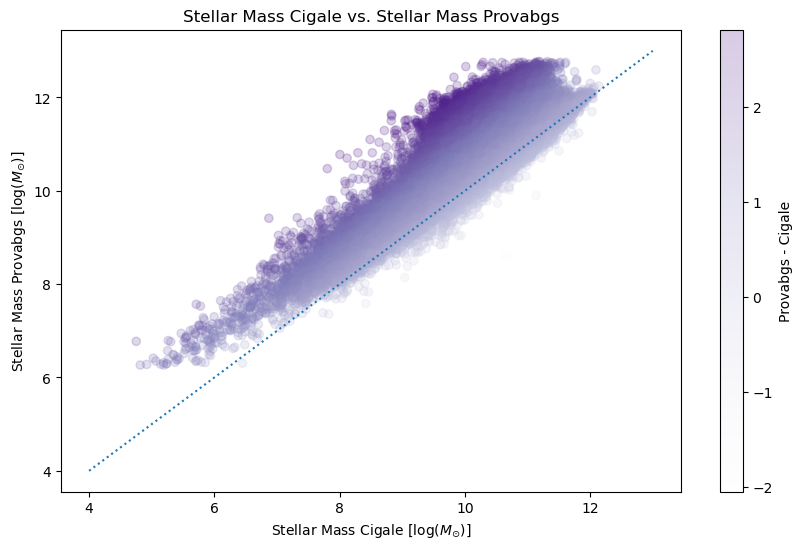

In [17]:
# stellar mass values
x = common_data_table['LOGM']
y = common_data_table_2['PROVABGS_LOGMSTAR_BF']

# calculate mass difference
mass_diff = y - x

# plot !
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, marker='o', c=mass_diff, cmap='Purples', alpha=0.2)
cbar = plt.colorbar(scatter)
cbar.set_label('Provabgs - Cigale')

plt.plot([4, 13], [4, 13], ls = ':')
plt.ylabel(r"Stellar Mass Provabgs [$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass Cigale [$\log(M_{\odot})$]")
plt.title("Stellar Mass Cigale vs. Stellar Mass Provabgs")

plt.savefig(v_dir + 'cigale_provabgs_plot.png', dpi=300)
plt.show()

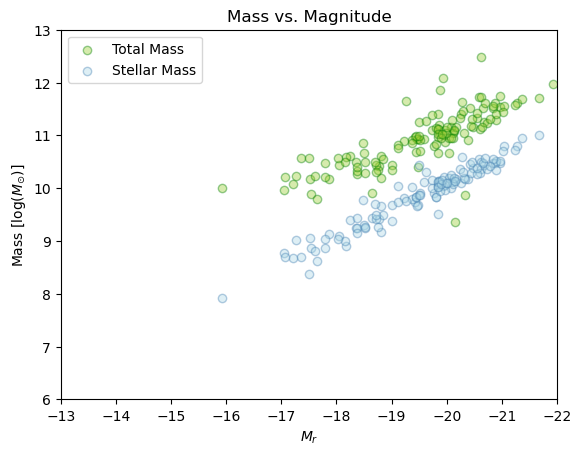

In [6]:
#total mass vs. cigale stellar mass plotting each mass only once
#plotting
x = sgas['RABS_MAG26']
y = sgas['M_R26']
w = sgas['RABS_MAG26']
z = sgas['M_STELLAR_CIGALE']
#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'Total Mass')
plt.scatter(w, z, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(6, 13)
plt.xlim(-13, -22)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'cigale_stellar_total__mass_magplot.png', dpi=300)

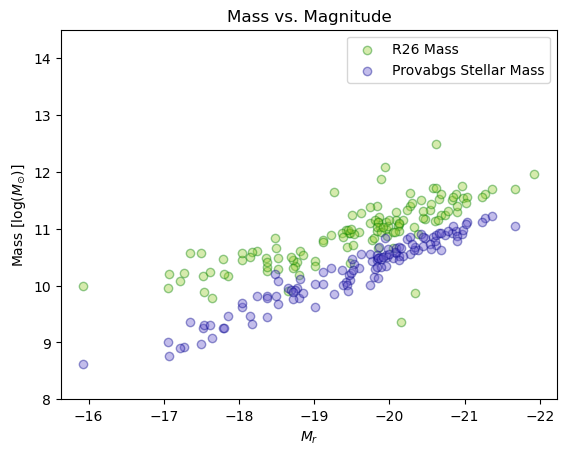

In [19]:
#total mass vs. provabgs stellar mass plotting each mass only once
#plotting
x = sgas['RABS_MAG26']
y = sgas['M_R26']
z = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'provabgs_stellar_total__mass_magplot.png', dpi=300)

In [ ]:
#total mass vs. provabgs stellar mass plotting each mass only once
#plotting
x = sgas['RABS_MAG26']
y = sgas['M_R26']
w = sgas['M_STELLAR_CIGALE']
z = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
plt.scatter(x, w, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'both_stellar_total__mass_magplot.png', dpi=300)

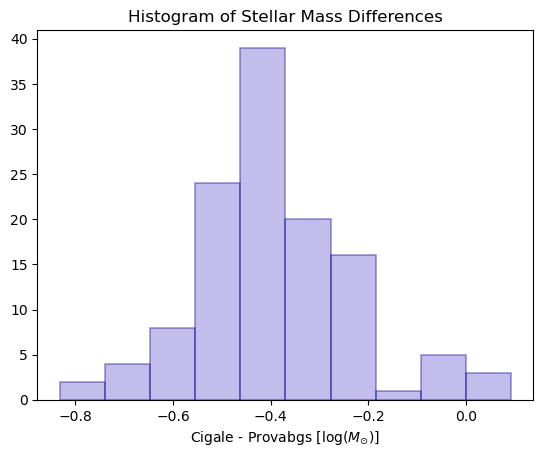

In [21]:
# Extracting stellar masses
m_stellar_cigale = sgas['M_STELLAR_CIGALE']
m_stellar_provabgs = sgas['M_STELLAR_PROVABGS']

# Calculating the difference
mass_difference = m_stellar_cigale - m_stellar_provabgs

# Plotting
plt.hist(mass_difference, bins=10,  color='slateblue', alpha = 0.4, edgecolor = 'darkblue', linewidth=1.2, label='Mass Difference')

plt.xlabel(r"Cigale - Provabgs [$\log(M_{\odot})$]")
plt.title("Histogram of Stellar Mass Differences")

plt.savefig(v_dir + 'histogram_stellar_mass_difference.png', dpi=300)
plt.show()

In [ ]:
#stellar mass vs total mass R26 for cigale
#plotting
y = sgas['M_R26']
x_cigale = sgas['M_STELLAR_CIGALE']
x_provabgs = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x_cigale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
#plt.ylim(8, 14)
#plt.xlim(8, 14)
#plt.plot([8, 14], [8,14], ls = ':')
plt.ylabel(r"$R_{26}$ Mass [$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass [$\log(M_{\odot})$]")
plt.title("Stellar Mass vs. R26 Mass")
plt.savefig(v_dir + 'cigale_stellar_r26__mass_plot.png', dpi=300)
plt.show()

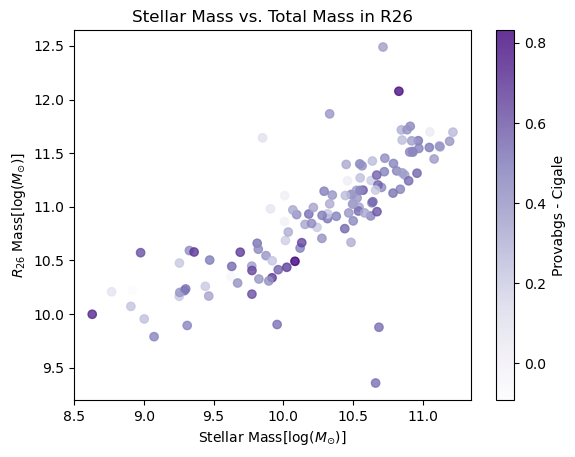

In [23]:
#stellar mass vs total mass R26 w color bar for mass diff in color bars
#plotting
y = sgas['M_R26']
x_cigale = sgas['M_STELLAR_CIGALE']
x = sgas['M_STELLAR_PROVABGS']

mass_diff = (x_provabgs - x_cigale)
#plot
#plt.scatter(x_cigale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
p = plt.scatter(x, y, marker='o', c = mass_diff, cmap = 'Purples', alpha = 0.8, label = 'Provabgs')
plt.colorbar(p, label = 'Provabgs - Cigale')
#plt.ylim(8, 14)
#plt.xlim(8, 14)
#plt.plot([8, 14], [8,14], ls = ':')
plt.ylabel(r"$R_{26}$ Mass[$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass[$\log(M_{\odot})$]")
plt.title("Stellar Mass vs. Total Mass in R26")
plt.savefig(v_dir + 'provabgs_stellar_cb__mass_plot.png', dpi=300)
plt.show()

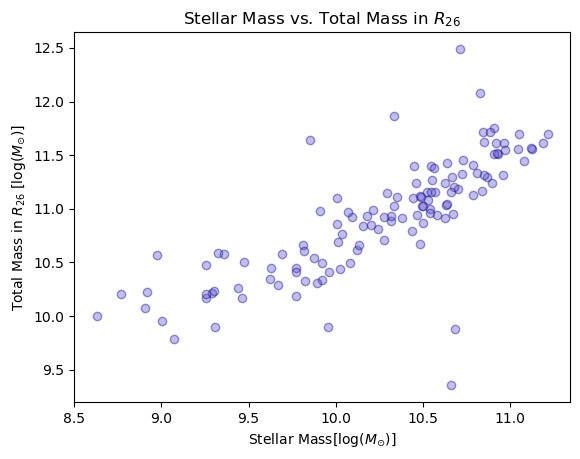

In [24]:
#stellar mass vs total mass R26 for provabgs
#plotting
y = sgas['M_R26']
x_cigale = sgas['M_STELLAR_CIGALE']
x_provabgs = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x_provabgs, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs')
#plt.ylim(8, 14)
#plt.xlim(8, 14)
#plt.plot([8, 14], [8,14], ls = ':')
plt.ylabel(r"Total Mass in $R_{26}$ [$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass[$\log(M_{\odot})$]")
plt.title(r"Stellar Mass vs. Total Mass in $R_{26}$")
plt.savefig(v_dir + 'provabgs_stellar_r26__mass_plot.png', dpi=300)
plt.show()

In [ ]:
#stellar mass vs total mass R26 for both
#plotting
y = sgas['M_R26']
x_cigale = sgas['M_STELLAR_CIGALE']
x_provabgs = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x_cigale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
plt.scatter(x_provabgs, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs')
plt.ylim(7.5, 14)
plt.xlim(7.5, 14)
plt.plot([7.5, 14], [7.5,14], ls = ':')
plt.ylabel(r"Total Mass in $R_{26}$ [$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass [$\log(M_{\odot})$]")
plt.title(r"Stellar Mass vs. Total Mass within $R_{26}$")
plt.legend()
plt.savefig(v_dir + 'stellar_total__mass_plot.png', dpi=300)
plt.show()

In [ ]:
#stellar mass vs total mass 3.5 R26 for both
#plotting
y = sgas['M_3P5R26']
x_cigale = sgas['M_STELLAR_CIGALE']
x_provabgs = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x_cigale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
plt.scatter(x_provabgs, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs')
plt.xlim(7, 12)
plt.ylim(7, 15)
plt.plot([7, 12], [7, 15], ls = ':')
plt.ylabel(r"Total Mass in 3.5 $R_{26}$ [$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass[$\log(M_{\odot})$]")
plt.title(r"Stellar Mass vs. Total Mass within 3.5 $R_{26}$")
plt.legend()
plt.savefig(v_dir + 'stellar_3p5_total__mass_plot.png', dpi=300)
plt.show()

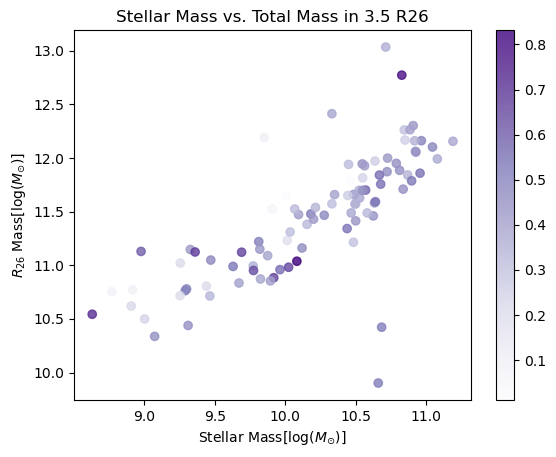

In [27]:
#stellar mass vs total mass R26 for cigale
#plotting
y = sgas['M_3P5R26']
x_cigale = sgas['M_STELLAR_CIGALE']
x = sgas['M_STELLAR_PROVABGS']

mass_diff = np.abs(x_cigale - x_provabgs)
#plot
#plt.scatter(x_cigale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
p = plt.scatter(x, y, marker='o', c = mass_diff, cmap = 'Purples', alpha = 0.8, label = 'Provabgs')
plt.colorbar(p)
#plt.ylim(8, 14)
#plt.xlim(8, 14)
#plt.plot([8, 14], [8,14], ls = ':')
plt.ylabel(r"$R_{26}$ Mass[$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass[$\log(M_{\odot})$]")
plt.title("Stellar Mass vs. Total Mass in 3.5 R26")
plt.savefig(v_dir + 'stellar_total_colorbar_3p5_plot.png', dpi=300)
plt.show()

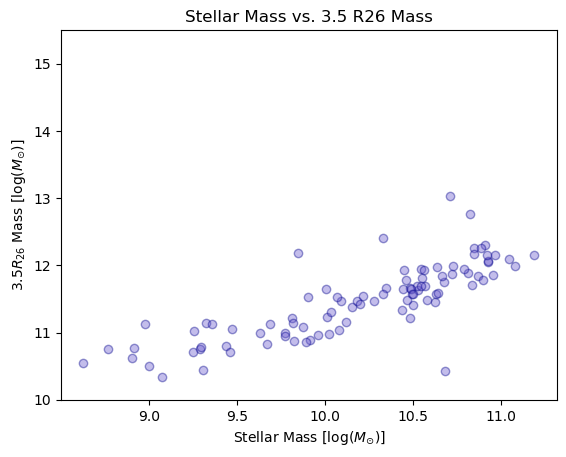

In [28]:
#stellar mass vs total mass 3.5 R26 for provabgs
#plotting
y = sgas['M_3P5R26']
x_cigale = sgas['M_STELLAR_CIGALE']
x_provabgs = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x_provabgs, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs')
plt.ylim(10, 15.5)
plt.ylabel(r"$3.5 R_{26}$ Mass [$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass [$\log(M_{\odot})$]")
plt.title("Stellar Mass vs. 3.5 R26 Mass")
plt.savefig(v_dir + 'provabgs_stellar_3p5r26__mass_plot.png', dpi=300)
plt.show()

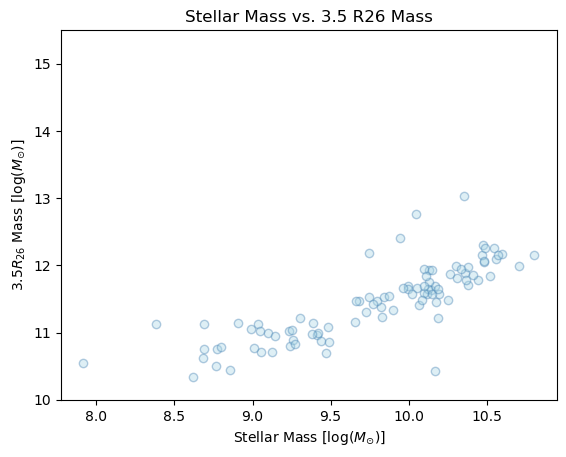

In [7]:
#stellar mass vs total mass 3.5 R26 for cigale
#plotting
y = sgas['M_3P5R26']
x_cigale = sgas['M_STELLAR_CIGALE']
x_provabgs = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x_cigale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
plt.ylim(10, 15.5)
plt.ylabel(r"$3.5 R_{26}$ Mass [$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass [$\log(M_{\odot})$]")
plt.title("Stellar Mass vs. 3.5 R26 Mass")
plt.savefig(v_dir + 'cigale_stellar_3p5_r26__mass_plot.png', dpi=300)
plt.show()

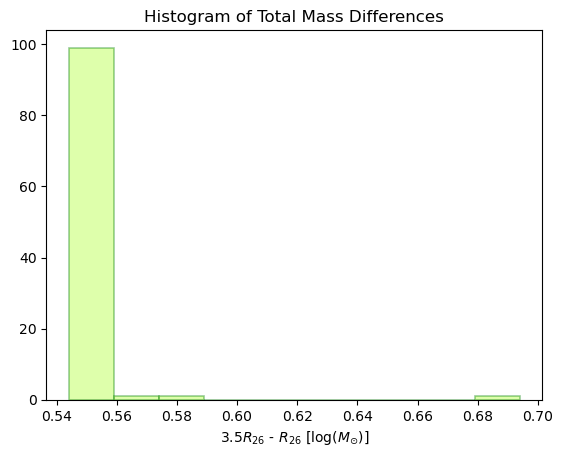

In [30]:
#Histogram of total mass diffs
# Extracting stellar masses
m_r26 = sgas['M_R26']
m_3p5_r26 = sgas['M_3P5R26']

# Calculating the difference
mass_difference = m_3p5_r26 - m_r26

# Plotting
plt.hist(mass_difference, bins=10, color='greenyellow', alpha=0.4, edgecolor='green', linewidth=1.2, label='Mass Difference')

plt.xlabel(r"$3.5 R_{26}$ - $R_{26}$ [$\log(M_{\odot})$]")
plt.title("Histogram of Total Mass Differences")

plt.savefig(v_dir + 'histogram_total_mass_difference.png', dpi=300)
plt.show()

/tmp/ipykernel_2251972/3934815832.py:7: RuntimeWarning: divide by zero encountered in log
  ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))
/tmp/ipykernel_2251972/3934815832.py:8: RuntimeWarning: divide by zero encountered in log
  ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))


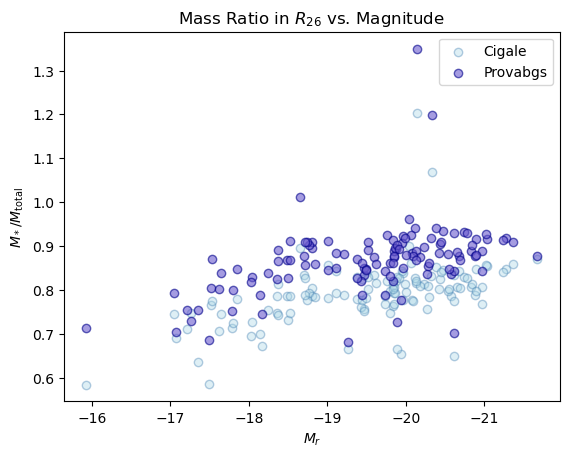

In [31]:
#ratio stellar mass to total mass within R26 using cigale and provabgs
m_star_cigale = sgas['M_STELLAR_CIGALE']
m_star_provabgs = sgas['M_STELLAR_PROVABGS']
mag = sgas['RABS_MAG26']
m_tot = sgas['M_R26']

ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))
ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))

#plot
plt.scatter(mag, ratio_c, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
plt.scatter(mag, ratio_p, marker='o', color='slateblue', alpha=0.6, edgecolors='darkblue', label='Provabgs')
plt.gca().invert_xaxis()
#plt.ylim(0.70, 1.10)
#plt.xlim(-15.5, -22.5)
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")
plt.legend()
plt.title(r"Mass Ratio in $R_{26}$ vs. Magnitude")
plt.savefig(v_dir + 'r26_mass_ratio_plot.png', dpi=300)
plt.show()

/tmp/ipykernel_2251972/423186199.py:6: RuntimeWarning: divide by zero encountered in log
  ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))


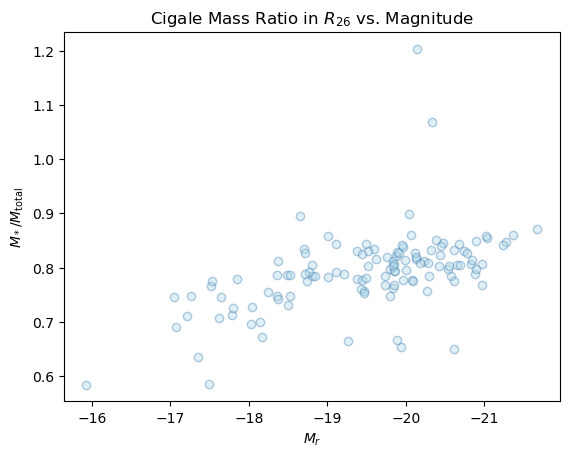

In [32]:
#ratio stellar mass to total mass within R26 using cigale only
m_star_cigale = sgas['M_STELLAR_CIGALE']
mag = sgas['RABS_MAG26']
m_tot = sgas['M_R26']

ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))

#plot
plt.scatter(mag, ratio_c, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
plt.gca().invert_xaxis()
#plt.ylim(0.70, 1.10)
#plt.xlim(-15.5, -22.5)
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")

plt.title(r"Cigale Mass Ratio in $R_{26}$ vs. Magnitude")
plt.savefig(v_dir + 'cigale_r26_mass_ratio_plot.png', dpi=300)
plt.show()

/tmp/ipykernel_2251972/575199553.py:6: RuntimeWarning: divide by zero encountered in log
  ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))


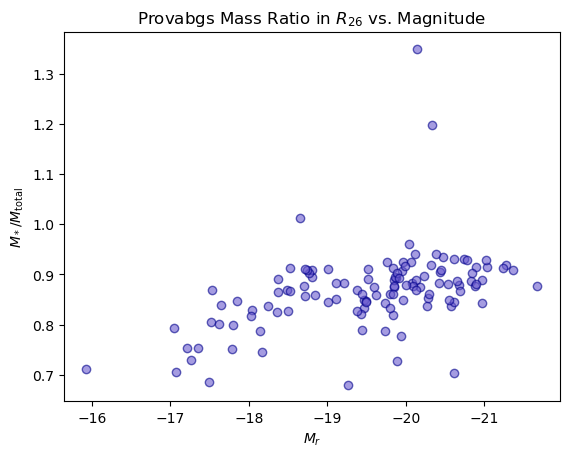

In [33]:
#ratio stellar mass to total mass within R26 using provabgs only
m_star_provabgs = sgas['M_STELLAR_PROVABGS']
mag = sgas['RABS_MAG26']
m_tot = sgas['M_R26']

ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))

#plot
plt.scatter(mag, ratio_p, marker='o', color='slateblue', alpha=0.6, edgecolors='darkblue', label='Provabgs')
plt.gca().invert_xaxis()
#plt.ylim(0.70, 1.10)
#plt.xlim(-15.5, -22.5)
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")

plt.title(r"Provabgs Mass Ratio in $R_{26}$ vs. Magnitude")
plt.savefig(v_dir + 'provabgs_r26_mass_ratio_plot.png', dpi=300)
plt.show()

/tmp/ipykernel_2251972/1517291514.py:7: RuntimeWarning: divide by zero encountered in log
  ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))
/tmp/ipykernel_2251972/1517291514.py:8: RuntimeWarning: divide by zero encountered in log
  ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))


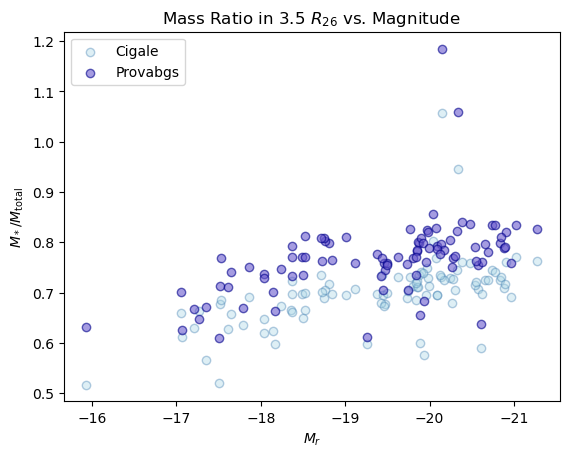

In [34]:
#ratio stellar mass to total mass within 3.5 R26 using cigale and provabgs
m_star_cigale = sgas['M_STELLAR_CIGALE']
m_star_provabgs = sgas['M_STELLAR_PROVABGS']
mag = sgas['RABS_MAG26']
m_tot = sgas['M_3P5R26']

ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))
ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))

#plot
plt.scatter(mag, ratio_c, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
plt.scatter(mag, ratio_p, marker='o', color='slateblue', alpha=0.6, edgecolors='darkblue', label='Provabgs')
plt.gca().invert_xaxis()
#plt.ylim(0.65, 1.10)
#plt.xlim(-15.5, -22.5)
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")
plt.legend()
plt.title(r"Mass Ratio in 3.5 $R_{26}$ vs. Magnitude")
plt.savefig(v_dir + '3p5_r26_mass_ratio_plot.png', dpi=300)
plt.show()

/tmp/ipykernel_2251972/1394304254.py:6: RuntimeWarning: divide by zero encountered in log
  ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))


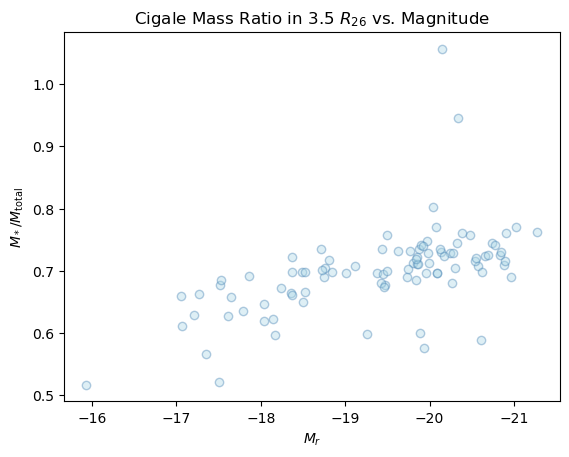

In [35]:
#ratio stellar mass to total mass within 3.5 R26 using cigale only
m_star_cigale = sgas['M_STELLAR_CIGALE']
mag = sgas['RABS_MAG26']
m_tot = sgas['M_3P5R26']

ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))

#plot
plt.scatter(mag, ratio_c, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
plt.gca().invert_xaxis()
#plt.ylim(0.65, 1.10)
#plt.xlim(-15.5, -22.5)
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")
plt.title(r"Cigale Mass Ratio in 3.5 $R_{26}$ vs. Magnitude")
plt.savefig(v_dir + 'cigale_3p5_r26_mass_ratio_plot.png', dpi=300)
plt.show()

/tmp/ipykernel_2251972/3838982976.py:6: RuntimeWarning: divide by zero encountered in log
  ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))


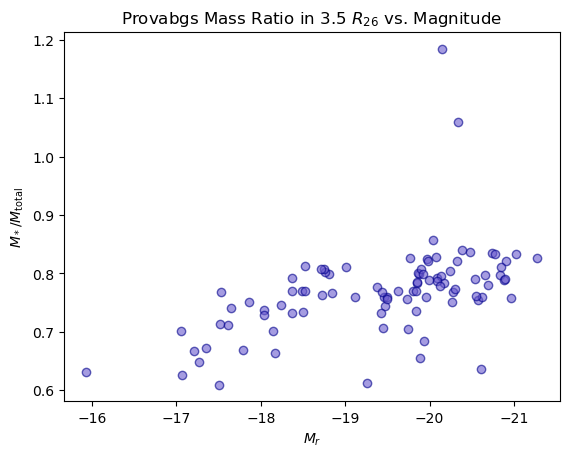

In [36]:
#ratio stellar mass to total mass within 3.5 R26 using provabgs only
m_star_provabgs = sgas['M_STELLAR_PROVABGS']
mag = sgas['RABS_MAG26']
m_tot = sgas['M_3P5R26']

ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))

#plot
plt.scatter(mag, ratio_p, marker='o', color='slateblue', alpha=0.6, edgecolors='darkblue', label='Provabgs')
plt.gca().invert_xaxis()
#plt.ylim(0.65, 1.10)
#plt.xlim(-15.5, -22.5)
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")

plt.title(r"Provabgs Mass Ratio in 3.5 $R_{26}$ vs. Magnitude")
plt.savefig(v_dir + 'provabgs_3p5_r26_mass_ratio_plot.png', dpi=300)
plt.show()

In [6]:
#writing new data into new table
tf_mastertable.write(data_dir + 'tf_mastertable_massmag_sv3.fits', format='fits', overwrite=True)